In [1]:
import sgkit_plink
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sgkit.stats import regenie
from pathlib import Path
import sgkit as sg
%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path('data/dataset/sim_01')
data_dir

PosixPath('data/dataset/sim_01')

In [3]:
variant_block_size = 100
sample_block_size = 50
alphas = np.array([1000.])

In [4]:
ds = sgkit_plink.read_plink(str(data_dir / 'genotypes'), bim_int_contig=True)
ds

<xarray.Dataset>
Dimensions:             (alleles: 2, ploidy: 2, samples: 250, variants: 1000)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    variant/contig      (variants) int16 dask.array<chunksize=(1000,), meta=np.ndarray>
    variant/position    (variants) int32 dask.array<chunksize=(1000,), meta=np.ndarray>
    variant/alleles     (variants, alleles) |S1 dask.array<chunksize=(1000, 1), meta=np.ndarray>
    sample/id           (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    call/genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(1000, 250, 2), meta=np.ndarray>
    call/genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(1000, 250, 2), meta=np.ndarray>
    variant/id          (variants) <U1 dask.array<chunksize=(1000,), meta=np.ndarray>
    sample/family_id    (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/paternal_id  (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/maternal_id  (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/sex          (samples) int8 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/phenotype    (samples) int8 dask.array<chunksize=(250,), meta=np.ndarray>
Attributes:
    contigs:  ['1']

In [5]:
ds['variant/position'].values[:50]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int32)

In [6]:
ds['variant/alleles'].values[:5]

array([[b'C', b'A'],
       [b'C', b'A'],
       [b'C', b'A'],
       [b'C', b'A'],
       [b'C', b'A']], dtype='|S1')

In [7]:
ds['variant/id'].values[:5]

array(['1:1:A:C', '1:2:A:C', '1:3:A:C', '1:4:A:C', '1:5:A:C'],
      dtype='<U10')

In [8]:
contigs = ds['variant/contig'].values
pd.Series(contigs).value_counts()

1    1000
dtype: int64

In [9]:
G = ds['call/genotype'].sum(dim='ploidy').values
G.shape

(1000, 250)

In [10]:
G[:5, :5]

array([[1, 1, 2, 2, 2],
       [2, 0, 1, 2, 0],
       [1, 1, 0, 1, 2],
       [2, 0, 1, 2, 1],
       [2, 0, 1, 0, 1]])

In [11]:
df_cov = pd.read_csv(str(data_dir / 'covariates.csv'), index_col='sample_id')
df_cov = ((df_cov - df_cov.mean()) / df_cov.std(ddof=0))
df_cov.head()

,X000,X001,X002
sample_id,,,
S0000001,1.720448,0.460089,1.159124
S0000002,2.185960,1.908391,-0.855966
S0000003,0.925824,-0.084248,0.044491
S0000004,0.399152,0.207309,1.649021
S0000005,0.741265,0.185231,0.608095


In [12]:
X = df_cov.values
X.shape

(250, 3)

In [13]:
df_trait = pd.read_csv(str(data_dir / 'traits.csv'), index_col='sample_id')
df_trait = ((df_trait - df_trait.mean()) / df_trait.std(ddof=0))
df_trait.head()

,Y0000
sample_id,
S0000001,0.012737
S0000002,1.653571
S0000003,1.291104
S0000004,-0.243287
S0000005,0.711926


In [14]:
Y = df_trait.values
Y.shape

(250, 1)

#### Run Sgkit WGR

In [61]:
res = regenie.regenie_transform(
    G.T, X, Y, 
    #G.T.astype(np.float32), X.astype(np.float32), Y.astype(np.float32), 
    contigs, 
    variant_block_size=variant_block_size, 
    sample_block_size=sample_block_size, 
    normalize=True, 
    add_intercept=False,
    alphas=alphas,
    orthogonalize=False,
    G_ddof=1 # Hack this in to get perfect match on Glow results
)

In [62]:
YP1, YP2, YP3 = res[:3]

In [63]:
# (n_variant_block, n_alpha, n_sample, n_outcome)
YP1

dask.array<stack, shape=(10, 1, 250, 1), dtype=float64, chunksize=(1, 1, 50, 1), chunktype=numpy.ndarray>

In [64]:
# n_sample, n_outcome
YP2

dask.array<stack, shape=(250, 1), dtype=float64, chunksize=(50, 1), chunktype=numpy.ndarray>

In [65]:
# n_contig, n_sample, n_outcome
YP3

dask.array<stack, shape=(1, 250, 1), dtype=float64, chunksize=(1, 50, 1), chunktype=numpy.ndarray>

#### Stage 1 Comparison

In [20]:
%%time
yp1 = YP1.compute()
yp1.shape

CPU times: user 370 ms, sys: 54.8 ms, total: 425 ms
Wall time: 298 ms


(10, 1, 250, 1)

In [21]:
yp1.dtype

dtype('float64')

In [22]:
np.allclose(yp1.mean(axis=2), 0)

False

In [23]:
np.allclose(yp1.std(axis=2), 1)

False

In [24]:
dfsg = (
    xr.DataArray(
        yp1, 
        dims=['variant_block_index', 'alpha_index', 'sample_index', 'outcome_index'], 
        name='sample_value'
    )
    .to_dataframe().reset_index()
)
dfsg

,variant_block_index,alpha_index,sample_index,outcome_index,sample_value
0,0,0,0,0,-0.056585
1,0,0,1,0,0.214959
2,0,0,2,0,0.216297
3,0,0,3,0,-0.258656
4,0,0,4,0,-0.182779
...,...,...,...,...,...
2495,9,0,245,0,-0.135062
2496,9,0,246,0,0.377874
2497,9,0,247,0,-0.418068
2498,9,0,248,0,-0.250813


In [25]:
def add_indexes(df):
    df['variant_block_index'] = df['header'].str.extract('block_(\d+)_').astype(int)
    df['sample_index'] = (df['sample_block'].astype(int) - 1) * df['size'] + df['sample_value_index'].astype(int)
    df['alpha_index'] = df['alpha'].str.extract('alpha_(\d+)').astype(int)
    df['outcome_index'] = df['label'].str.extract('Y(\d+)').astype(int)
    return df

dfgl = pd.read_parquet('data/result/glow/sim_01-v100-b50/reduced_blocks_flat.parquet')
dfgl = add_indexes(dfgl)
dfgl = dfgl.drop(['sample_value_index'], axis=1)
assert dfgl['sample_block'].nunique() == (G.shape[1] // sample_block_size)
assert dfgl['variant_block_index'].nunique() == (G.shape[0] // variant_block_size)
dfgl

,header,size,header_block,sample_block,sort_key,mu,sig,alpha,label,sample_value,variant_block_index,sample_index,alpha_index,outcome_index
0,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,-0.214096,6,50,0,0
1,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,-0.062973,6,51,0,0
2,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,0.632400,6,52,0,0
3,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,-0.421000,6,53,0,0
4,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,0.438188,6,54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,chr_1_block_1_alpha_0_label_Y0000,50,chr_1,1,1,0.031098,0.239239,alpha_0,Y0000,0.130484,1,45,0,0
2496,chr_1_block_1_alpha_0_label_Y0000,50,chr_1,1,1,0.031098,0.239239,alpha_0,Y0000,0.495571,1,46,0,0
2497,chr_1_block_1_alpha_0_label_Y0000,50,chr_1,1,1,0.031098,0.239239,alpha_0,Y0000,0.010938,1,47,0,0
2498,chr_1_block_1_alpha_0_label_Y0000,50,chr_1,1,1,0.031098,0.239239,alpha_0,Y0000,0.392789,1,48,0,0


In [26]:
dfsg.filter(regex='_index').describe().loc[['min', 'max']].astype(int).sort_index(axis=1)

,alpha_index,outcome_index,sample_index,variant_block_index
min,0,0,0,0
max,0,0,249,9


In [27]:
dfgl.filter(regex='_index').describe().loc[['min', 'max']].astype(int).sort_index(axis=1)

,alpha_index,outcome_index,sample_index,variant_block_index
min,0,0,0,0
max,0,0,249,9


In [28]:
cols = dfsg.filter(regex='_index').columns.tolist()
dfcomp = pd.concat([
    dfsg.set_index(cols)['sample_value'].rename('value_sgkit'),
    dfgl.set_index(cols)['sample_value'].rename('value_glow')
], axis=1, join='outer')
assert len(dfcomp.dropna()) == len(dfsg) == len(dfgl)
dfcomp.head()

value_sgkit  \
variant_block_index alpha_index sample_index outcome_index                
0                   0           0            0                -0.056585   
                                1            0                 0.214959   
                                2            0                 0.216297   
                                3            0                -0.258656   
                                4            0                -0.182779   

                                                            value_glow  
variant_block_index alpha_index sample_index outcome_index              
0                   0           0            0               -0.056585  
                                1            0                0.214959  
                                2            0                0.216297  
                                3            0               -0.258656  
                                4            0               -0.182779

In [29]:
dfcomp.describe()

,value_sgkit,value_glow
count,2500.000000,2500.000000
mean,-0.006590,-0.006590
std,0.293981,0.293981
min,-0.934239,-0.934239
25%,-0.204905,-0.204905
50%,-0.005911,-0.005911
75%,0.201846,0.201846
max,0.891894,0.891894


In [30]:
dfcomp.reset_index().groupby(['variant_block_index', 'sample_index'])['value_glow'].mean().describe()

count    2500.000000
mean       -0.006590
std         0.293981
min        -0.934239
25%        -0.204905
50%        -0.005911
75%         0.201846
max         0.891894
Name: value_glow, dtype: float64

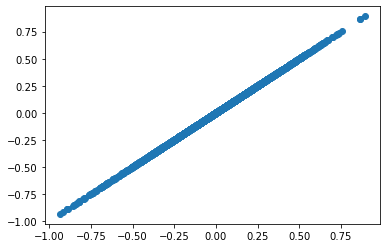

In [31]:
plt.scatter(dfcomp['value_glow'].sort_values().values, dfcomp['value_sgkit'].sort_values().values)

<AxesSubplot:xlabel='value_glow', ylabel='value_sgkit'>

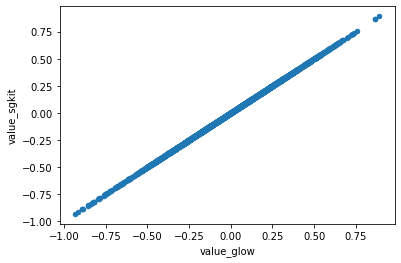

In [32]:
dfcomp.plot(kind='scatter', x='value_glow', y='value_sgkit')

<AxesSubplot:>

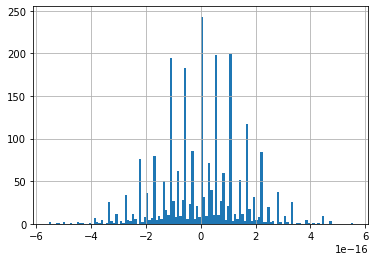

In [33]:
(dfcomp['value_sgkit'] - dfcomp['value_glow']).hist(bins=128)

In [34]:
np.testing.assert_allclose(dfcomp['value_sgkit'], dfcomp['value_glow'], atol=1e-14)

### Stage 2 Comparison

In [35]:
# dft = pd.read_parquet('result/glow/sim_01-v100-b50/reduced_blocks_flat.parquet')
# dft.head()
# dft['header'].unique()

In [36]:
%%time
yp2 = YP2.compute()
yp2.shape

CPU times: user 426 ms, sys: 60.1 ms, total: 486 ms
Wall time: 359 ms


(250, 1)

In [37]:
dfgl = pd.read_csv('data/result/glow/sim_01-v100-b50/predictions.csv', index_col='sample_id')
dfgl.head()

,Y0000
sample_id,
S0000001,0.005314
S0000002,0.096403
S0000003,0.108917
S0000004,-0.153500
S0000005,-0.007197


In [38]:
assert yp2.shape == dfgl.shape
dfsg = pd.DataFrame(yp2, columns=dfgl.columns, index=dfgl.index)
dfsg.head()

,Y0000
sample_id,
S0000001,0.005314
S0000002,0.096403
S0000003,0.108917
S0000004,-0.153500
S0000005,-0.007197


In [39]:
dfcomp = pd.concat([
    dfsg.rename_axis('outcome', axis='columns').stack().rename('value_sgkit'),
    dfgl.rename_axis('outcome', axis='columns').stack().rename('value_glow'),
], axis=1, join='outer')
assert len(dfcomp.dropna()) == len(dfsg) == len(dfgl)
dfcomp.head()

,,value_sgkit,value_glow
sample_id,outcome,,
S0000001,Y0000,0.005314,0.005314
S0000002,Y0000,0.096403,0.096403
S0000003,Y0000,0.108917,0.108917
S0000004,Y0000,-0.153500,-0.153500
S0000005,Y0000,-0.007197,-0.007197


<AxesSubplot:xlabel='value_glow', ylabel='value_sgkit'>

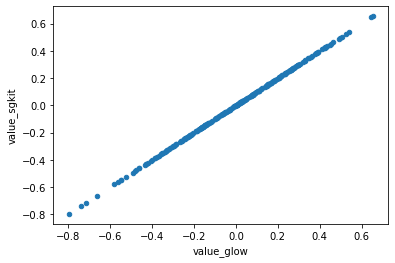

In [40]:
dfcomp.plot(kind='scatter', x='value_glow', y='value_sgkit')

<AxesSubplot:>

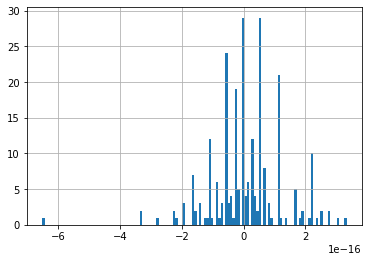

In [41]:
(dfcomp['value_sgkit'] - dfcomp['value_glow']).hist(bins=128)

In [42]:
np.testing.assert_allclose(dfcomp['value_sgkit'], dfcomp['value_glow'], atol=1e-14)

### Stage 3 Comparison

In [43]:
y_residual = Y - yp2
y_residual.shape

(250, 1)

In [44]:
# Xt = X.ravel(order='C').reshape(X.shape, order='F')
# Xt[:5]

In [45]:
X[:5]

array([[ 1.72044832,  0.46008878,  1.15912404],
       [ 2.18595953,  1.90839095, -0.85596564],
       [ 0.92582401, -0.08424753,  0.04449093],
       [ 0.39915227,  0.20730853,  1.64902126],
       [ 0.74126513,  0.18523111,  0.60809549]])

In [46]:
data_vars = {
    'genotypes': xr.DataArray(G, dims=('variants', 'samples')),
    'outcome_1': xr.DataArray(y_residual[:, 0], dims=('samples')),
    'variant_id': ds['variant/id']
}
for i in range(X.shape[1]):
    data_vars[f'covar_{i}'] = xr.DataArray(X[:, i], dims=('samples'))
    #data_vars[f'covar_{i}'] = xr.DataArray(Xt[:, i], dims=('samples'))
ds_gwas = xr.Dataset(data_vars)
ds_gwas

<xarray.Dataset>
Dimensions:     (samples: 250, variants: 1000)
Dimensions without coordinates: samples, variants
Data variables:
    genotypes   (variants, samples) int64 1 1 2 2 2 1 1 0 0 ... 2 0 2 0 2 2 0 0
    outcome_1   (samples) float64 0.007423 1.557 1.182 ... -1.665 -0.386 -0.3655
    variant_id  (variants) <U1 dask.array<chunksize=(1000,), meta=np.ndarray>
    covar_0     (samples) float64 1.72 2.186 0.9258 ... -1.115 -0.7492 0.7012
    covar_1     (samples) float64 0.4601 1.908 -0.08425 ... 1.797 0.6137 -1.735
    covar_2     (samples) float64 1.159 -0.856 0.04449 ... 0.01382 0.1615 0.4636

In [47]:
from sgkit.stats import association
import imp
imp.reload(association)

<module 'sgkit.stats.association' from '/home/jovyan/work/repos/sgkit/sgkit/stats/association.py'>

In [48]:
ds_stats = association.gwas_linear_regression(
    ds_gwas, 
    dosage='genotypes',
    covariates=[f'covar_{i}' for i in range(X.shape[1])],
    trait='outcome_1',
    add_intercept=False
).merge(ds_gwas[['variant_id']])
dfsg = ds_stats.to_dataframe()
dfsg = dfsg.assign(outcome='Y0000') # Hack in for now
dfsg = dfsg.rename(columns=lambda c: c.replace('variant/', ''))
dfsg.head()

,beta,t_value,p_value,variant_id,outcome
variants,,,,,
0,0.052163,1.052691,0.293516,1:1:A:C,Y0000
1,-0.055254,-1.078192,0.282004,1:2:A:C,Y0000
2,-0.027293,-0.552725,0.580954,1:3:A:C,Y0000
3,-0.025790,-0.512215,0.608960,1:4:A:C,Y0000
4,-0.013614,-0.269783,0.787554,1:5:A:C,Y0000


In [49]:
import json
dfgl = pd.read_csv('data/result/glow/sim_01-v100-b50/gwas.csv')
dfgl = dfgl.rename(columns={'pValue': 'p_value', 'label': 'outcome'})
dfgl = dfgl.drop('standardError', axis=1)
dfgl['names'] = dfgl['names'].apply(eval)
assert np.all(dfgl['names'].apply(len) == 1)
dfgl['variant_id'] = dfgl['names'].apply(lambda v: v[0])
dfgl = dfgl.drop('names', axis=1)
dfgl.head()

,start,outcome,beta,standardError,p_value,variant_id
0,0,Y0000,0.052163,0.049552,0.293516,1:1:A:C
1,1,Y0000,-0.055254,0.051247,0.282004,1:2:A:C
2,2,Y0000,-0.027293,0.049379,0.580954,1:3:A:C
3,3,Y0000,-0.025790,0.050350,0.608960,1:4:A:C
4,4,Y0000,-0.013614,0.050463,0.787554,1:5:A:C


In [51]:
dfcomp = pd.concat([
    dfsg.set_index(['outcome', 'variant_id'])[['beta', 'p_value']].add_suffix('_sgkit'),
    dfgl.set_index(['outcome', 'variant_id'])[['beta', 'p_value']].add_suffix('_glow'),
], axis=1, join='outer')
assert len(dfcomp.dropna()) == len(dfsg) == len(dfgl)
dfcomp.head()

beta_sgkit  p_value_sgkit  beta_glow  p_value_glow
outcome variant_id                                                    
Y0000   1:1:A:C       0.052163       0.293516   0.052163      0.293516
        1:2:A:C      -0.055254       0.282004  -0.055254      0.282004
        1:3:A:C      -0.027293       0.580954  -0.027293      0.580954
        1:4:A:C      -0.025790       0.608960  -0.025790      0.608960
        1:5:A:C      -0.013614       0.787554  -0.013614      0.787554

In [52]:
np.any(np.isclose(dfcomp['beta_sgkit'], dfcomp['beta_glow']))

True

<AxesSubplot:xlabel='beta_glow', ylabel='beta_sgkit'>

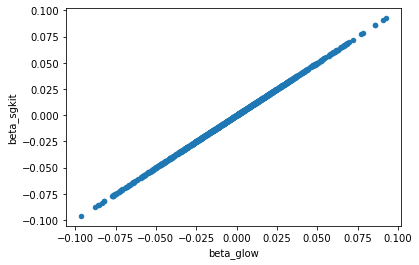

In [54]:
dfcomp.plot(kind='scatter', x='beta_glow', y='beta_sgkit')

<AxesSubplot:xlabel='p_value_glow', ylabel='p_value_sgkit'>

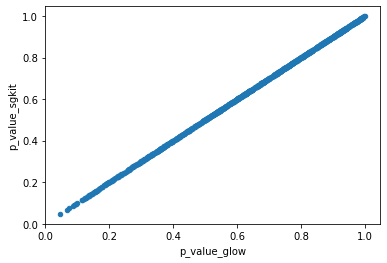

In [55]:
dfcomp.plot(kind='scatter', x='p_value_glow', y='p_value_sgkit')

<AxesSubplot:>

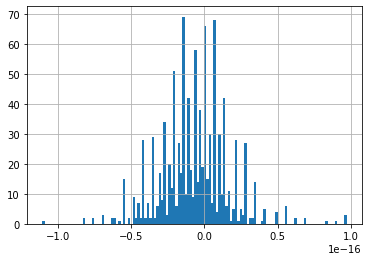

In [56]:
(dfcomp['beta_sgkit'] - dfcomp['beta_glow']).hist(bins=128)

In [57]:
np.testing.assert_allclose(dfcomp['beta_sgkit'], dfcomp['beta_glow'], atol=1e-14)

In [58]:
np.testing.assert_allclose(dfcomp['p_value_sgkit'], dfcomp['p_value_glow'], atol=1e-14)